# Image Segmentation

In [1]:
# %pip install git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf

import tensorflow_datasets as tfds

c:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#  image-to-image translation tasks
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Downloading the Oxford-IIIT Pets dataset

[Dataset](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1  # values start from 0
  return input_image, input_mask

In [6]:
def load_image(datapoint): # image and its corresponding segmentation mask
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000   # shuffling dataset
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Simple augmentation by randomly-flipping an image.


In [9]:
# Showing the model different versions of the same picture to help it learn better.

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

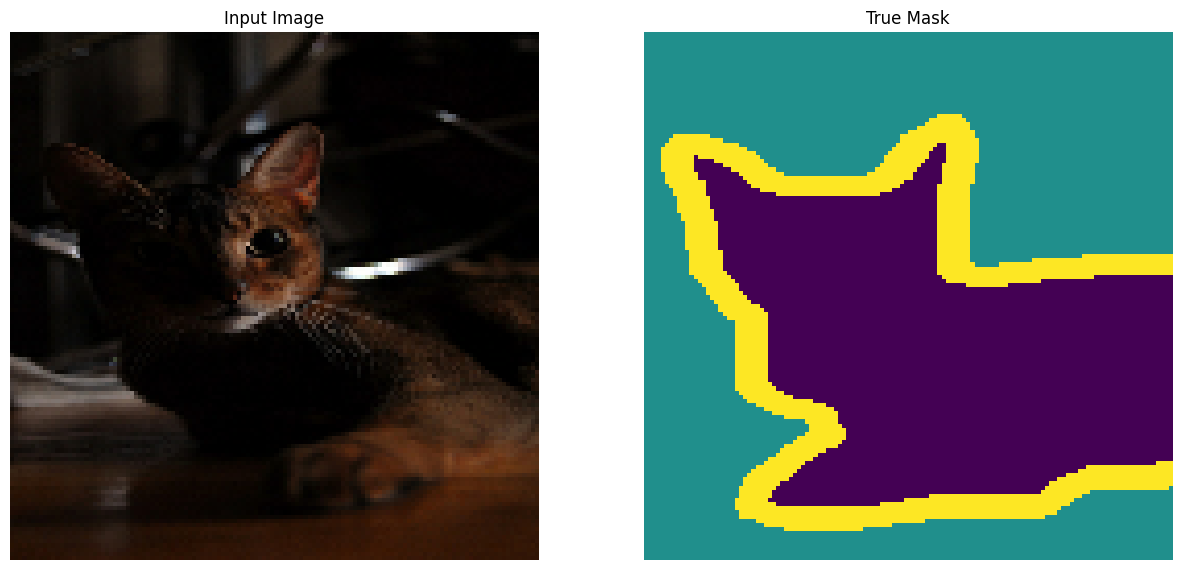

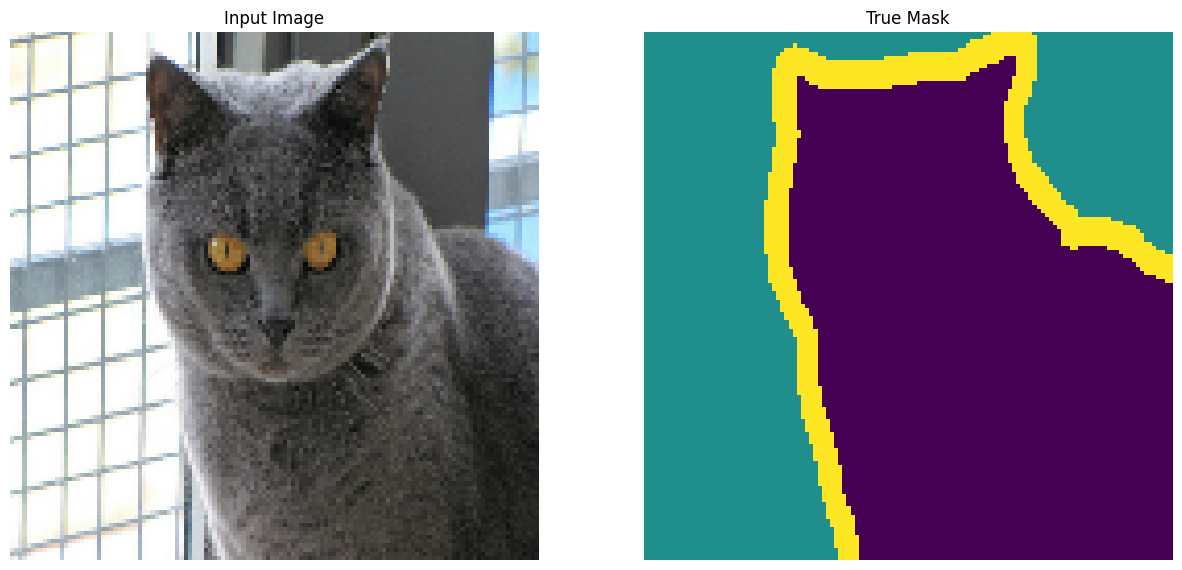

In [12]:
for images, masks in train_batches.take(2): # 2 batches
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler).


Here encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

 #### Increases the spatial dimensions of an input feature map while reducing the number of channels

In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [15]:
# encoder-decoder structure with skip connections between corresponding encoder and decoder layers.

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling reduce spatial dimensions
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Outputs segmentation masks of the specified number of channels
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Training the model
 
Since this is a multiclass classification problem,we are using the `tf.keras.losses.CategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [16]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
### creates segmentation mask

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


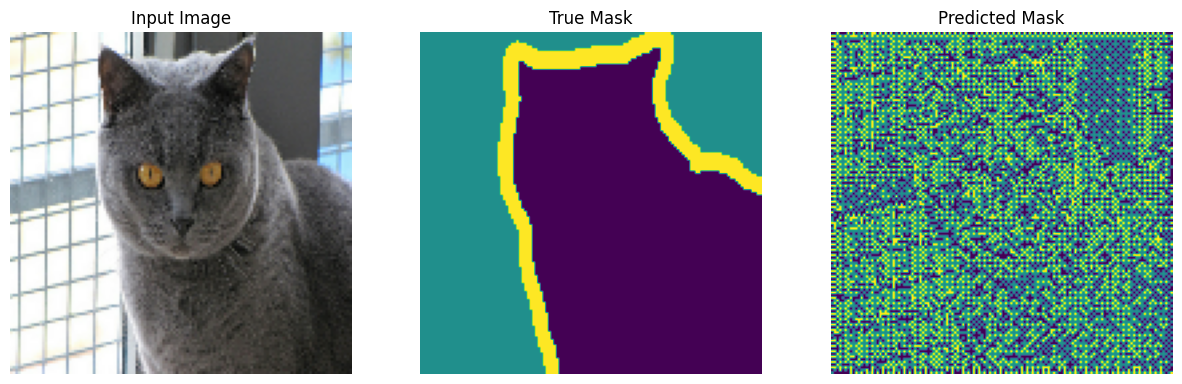

In [20]:
show_predictions()

Callback here is used to observe how the model improves while it is training:

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


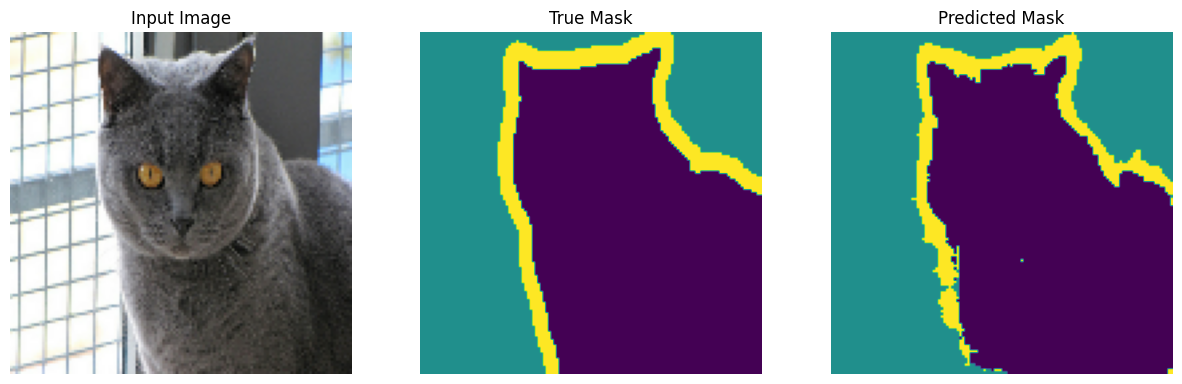


Sample Prediction after epoch 5

57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9000 - loss: 0.2566 - val_accuracy: 0.8976 - val_loss: 0.2635


In [22]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

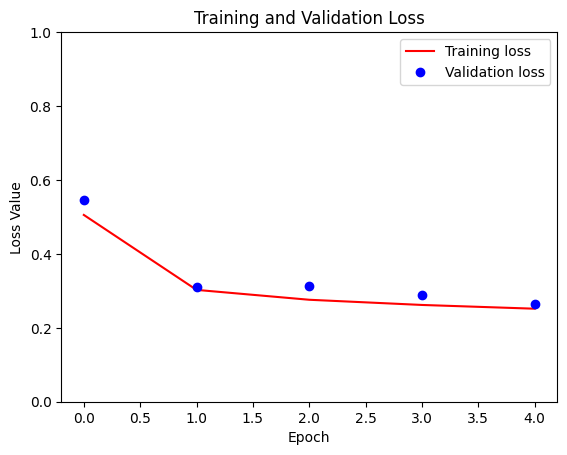

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step


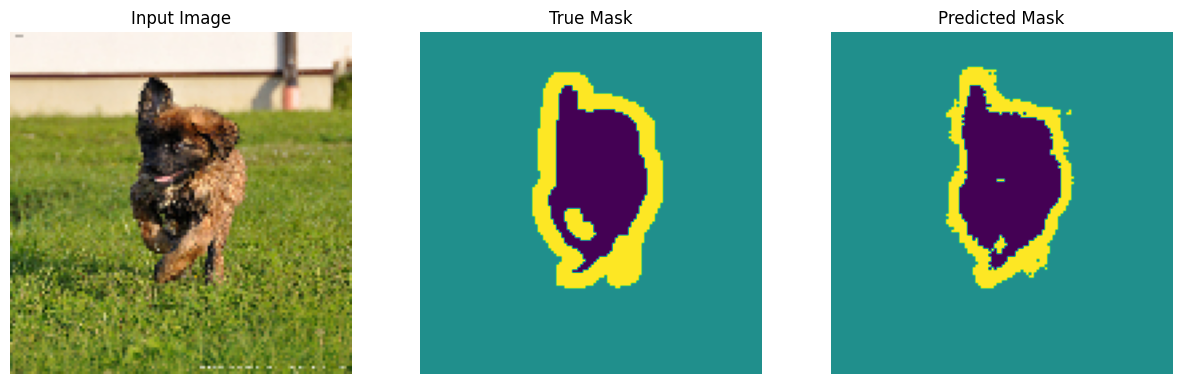

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


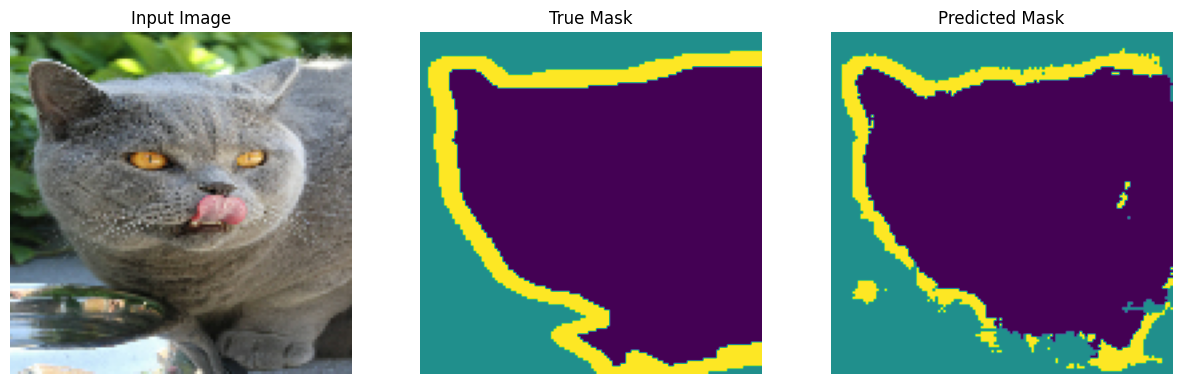

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


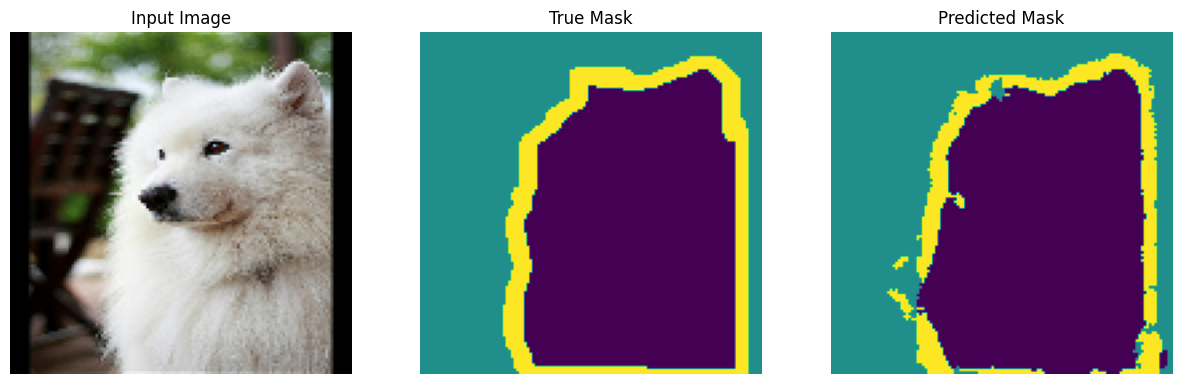

In [24]:
show_predictions(test_batches, 3)

In [40]:
# Save the model
model.export('my_model')
# Print the saved location
print('Saved model to: {}'.format('model.keras'))

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Saved artifact at 'my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_156')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  1597270578224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270587200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270578576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270574704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270587376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270587728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270578048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270588608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270586848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270587904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270588080: TensorSpec(sh

Testing the loaded model on sample_image
--------------------------------------
Predicted mask:
tf.Tensor(
[[[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 ...

 [[1]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]

 [[1]
  [1]
  [1]
  ...
  [0]
  [2]
  [2]]

 [[1]
  [1]
  [1]
  ...
  [0]
  [2]
  [2]]], shape=(128, 128, 1), dtype=int64)
True mask:


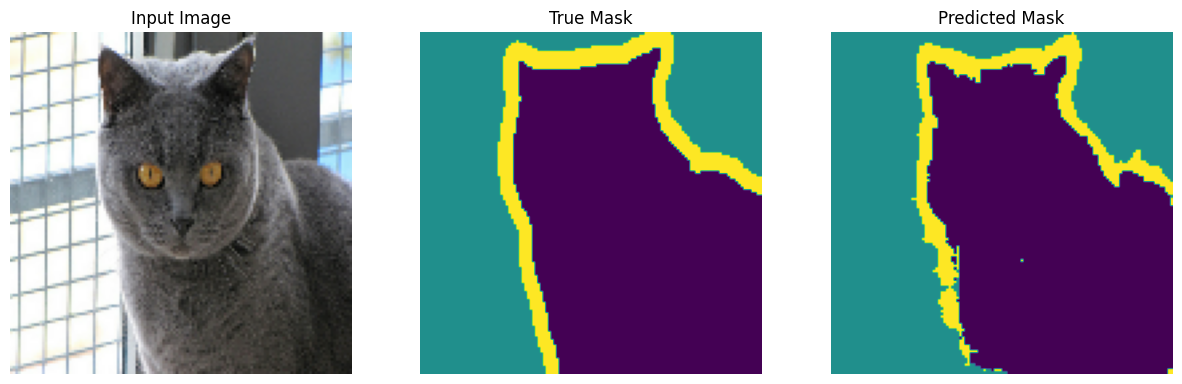

In [42]:
loaded_model = tf.saved_model.load('my_model')


# Test the loaded model on sample_image
print('Testing the loaded model on sample_image')
print('--------------------------------------')
print('Predicted mask:')
pred_mask = loaded_model.serve(sample_image[tf.newaxis, ...])
print(create_mask(pred_mask))
print('True mask:')
# print(sample_mask)
display([sample_image, sample_mask, create_mask(pred_mask)])


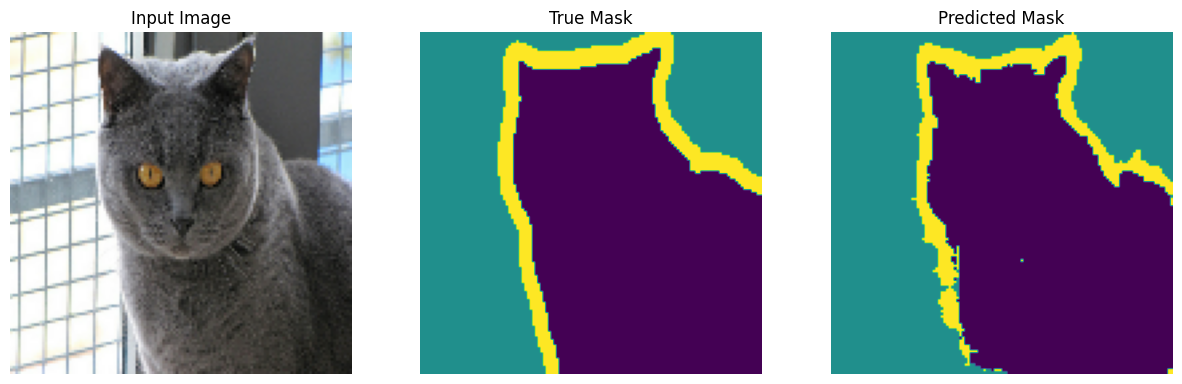

In [43]:
# Show the original image and the prediction
display([sample_image, sample_mask, create_mask(pred_mask)])


## For Imbalanced classes and class weights

In [44]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8976 - loss: 0.3733
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8993 - loss: 0.3652
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9026 - loss: 0.3461
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9028 - loss: 0.3459
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9056 - loss: 0.3295
Expected AssertionError: 


Here Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [47]:
## loss = ground - predicted loss       || calculated loss for individual classes

import numpy as np
label = np.array([0,0])
prediction = np.array([[-3., 0], [-3, 0]])
sample_weight = np.array([1, 10]) 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3.0485873, 30.485874 ], dtype=float32)>

In [48]:
## These sample weights can be used during model training to give more or less importance to different samples based on their classes

def add_sample_weights(image, label):
  
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [49]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Training a model on this weighted dataset:

In [ ]:
# encoder-decoder structure with skip connections between corresponding encoder and decoder layers.

weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [51]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4969 - loss: 0.3954


In [53]:
# Save the model
weighted_model.export('final_model')

INFO:tensorflow:Assets written to: final_model\assets


INFO:tensorflow:Assets written to: final_model\assets


Saved artifact at 'final_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_855')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  1597270578224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270587200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270578576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270574704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270587376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270587728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270578048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270588608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270586848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270587904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1597270588080: TensorSpec